# Model Bias Analysis for BRSET Fundus Image Classification

This notebook calculates metrics and bias for the model's predictions across demographic groups (age and sex). It evaluates overall performance, as well as separate metrics for Drusen presence and absence.

## 1. Import Libraries

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

## 2. Load Prediction Results

In [2]:
# Load the results from the saved files
age_results_path = 'drusens_only/experiment1_ages/results/age_experiment_results_gpt4o.csv'
sex_results_path = 'drusens_only/experiment2_genders/results/sex_experiment_results_gpt4o.csv'

age_results = pd.read_csv(age_results_path)
sex_results = pd.read_csv(sex_results_path)

## 3. Define Metrics Calculation Function with Separate Analysis for Presence and Absence

In [3]:
def calculate_bias_metrics(df, group_column, target_column='drusens_actual', prediction_column='drusens_predicted'):
    """
    Calculate expanded bias metrics across demographic groups, for overall, Drusen presence, and Drusen absence.
    """
    metrics = {}

    for group in df[group_column].unique():
        group_df = df[df[group_column] == group]
        y_true = group_df[target_column]
        y_pred = group_df[prediction_column]

        # Overall metrics
        accuracy = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        demographic_parity = (tp + fp) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
        calibration = f1_score(y_true, y_pred)

        # Overall Precision, Recall, FDR, and FOR
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        fdr = fp / (tp + fp) if (tp + fp) > 0 else 0  # False Discovery Rate
        for_rate = fn / (fn + tn) if (fn + tn) > 0 else 0  # False Omission Rate

        # Metrics for Drusen presence (positive class)
        precision_presence = precision_score(y_true, y_pred, pos_label=1)
        recall_presence = recall_score(y_true, y_pred, pos_label=1)
        f1_presence = f1_score(y_true, y_pred, pos_label=1)

        # Metrics for Drusen absence (negative class)
        precision_absence = precision_score(y_true, y_pred, pos_label=0)
        recall_absence = recall_score(y_true, y_pred, pos_label=0)
        f1_absence = f1_score(y_true, y_pred, pos_label=0)

        metrics[group] = {
            'Overall Accuracy': accuracy,
            'Overall FPR': fpr,
            'Overall FNR': fnr,
            'Overall Demographic Parity': demographic_parity,
            'Overall Calibration': calibration,
            'Overall Precision': precision,
            'Overall Recall': recall,
            'Overall FDR': fdr,
            'Overall FOR': for_rate,
            'Presence Precision': precision_presence,
            'Presence Recall': recall_presence,
            'Presence F1': f1_presence,
            'Absence Precision': precision_absence,
            'Absence Recall': recall_absence,
            'Absence F1': f1_absence
        }

    return pd.DataFrame(metrics).T


## 4. Calculate Metrics for Age and Sex Groups

In [4]:
age_metrics = calculate_bias_metrics(age_results, 'age_group')
sex_metrics = calculate_bias_metrics(sex_results, 'patient_sex')

## 5. Display Metrics

In [5]:
print("Age Experiment Metrics:")
display(age_metrics)
print("\nSex Experiment Metrics:")
display(sex_metrics)

Age Experiment Metrics:


,Overall Accuracy,Overall FPR,Overall FNR,Overall Demographic Parity,Overall Calibration,Overall Precision,Overall Recall,Overall FDR,Overall FOR,Presence Precision,Presence Recall,Presence F1,Absence Precision,Absence Recall,Absence F1
Young,0.62,0.266667,0.550000,0.34,0.486486,0.529412,0.450000,0.470588,0.333333,0.529412,0.450000,0.486486,0.666667,0.733333,0.698413
Middle-aged,0.64,0.360000,0.360000,0.50,0.640000,0.640000,0.640000,0.360000,0.360000,0.640000,0.640000,0.640000,0.640000,0.640000,0.640000
Older,0.62,0.478261,0.296296,0.60,0.666667,0.633333,0.703704,0.366667,0.400000,0.633333,0.703704,0.666667,0.600000,0.521739,0.558140



Sex Experiment Metrics:


,Overall Accuracy,Overall FPR,Overall FNR,Overall Demographic Parity,Overall Calibration,Overall Precision,Overall Recall,Overall FDR,Overall FOR,Presence Precision,Presence Recall,Presence F1,Absence Precision,Absence Recall,Absence F1
1,0.60,0.300000,0.466667,0.44,0.615385,0.727273,0.533333,0.272727,0.500000,0.727273,0.533333,0.615385,0.500000,0.700000,0.583333
2,0.68,0.473684,0.225806,0.66,0.750000,0.727273,0.774194,0.272727,0.411765,0.727273,0.774194,0.750000,0.588235,0.526316,0.555556


## 6. Plot Metrics for Visual Comparison

In [6]:
# Map numeric sex values to labels in the sex metrics DataFrame
sex_metrics.index = sex_metrics.index.map({1: 'Male', 2: 'Female'})

### Plot Overall Metrics by Age and Sex Experiments

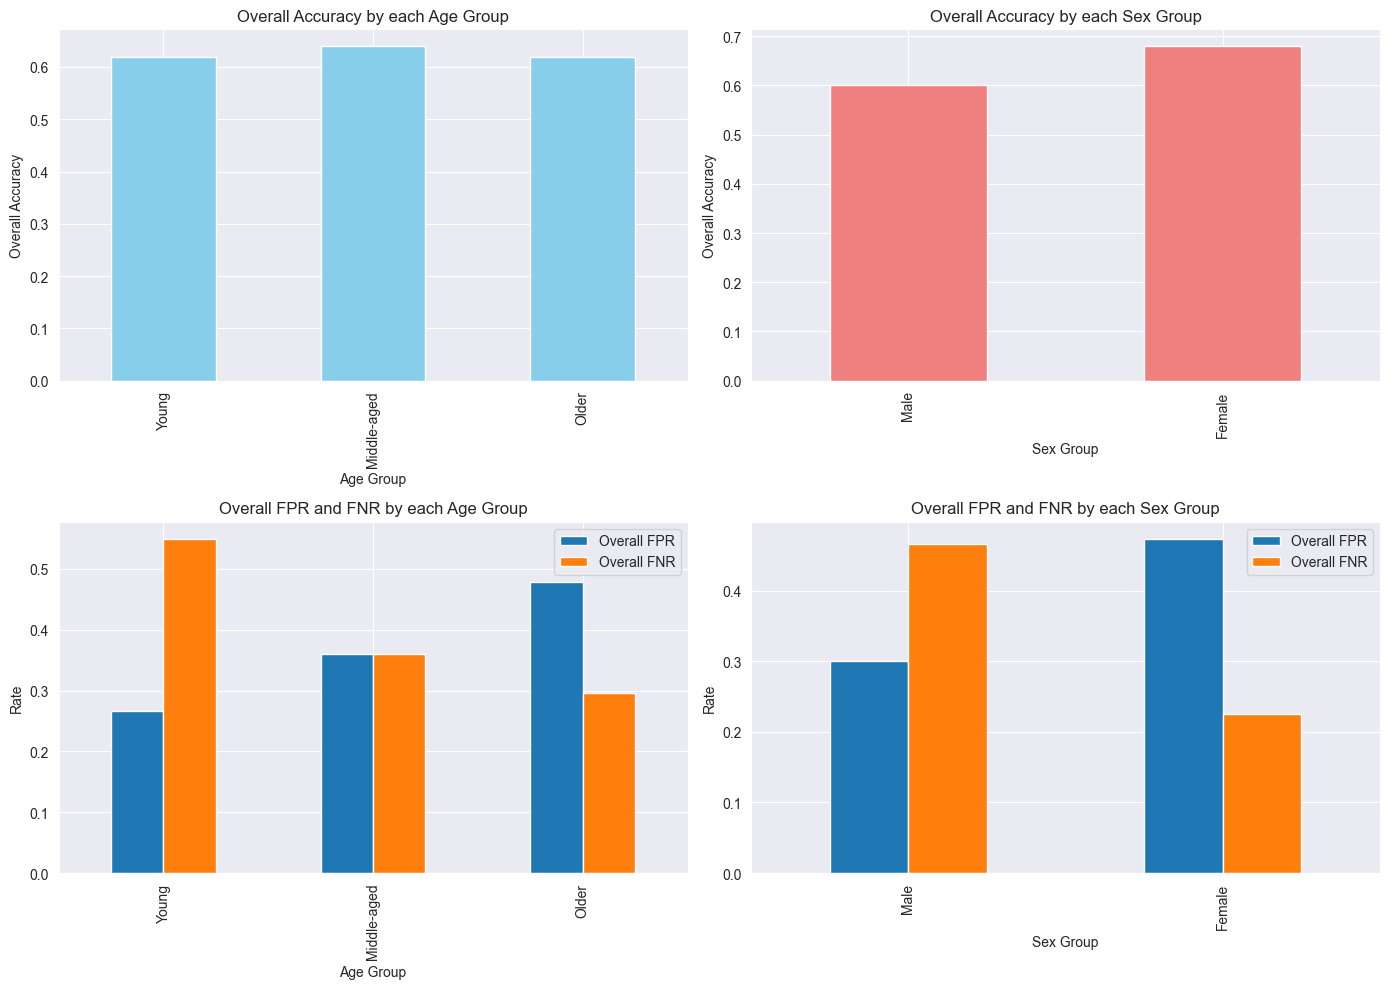

In [7]:
# Create subplots with 2 plots per row for overall accuracy and FPR/FNR
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall Accuracy by Age Group
age_metrics['Overall Accuracy'].plot(kind='bar', ax=axes[0, 0], color='skyblue', title='Overall Accuracy by each Age Group')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Overall Accuracy')


# Overall Accuracy by Sex Group
sex_metrics['Overall Accuracy'].plot(kind='bar', ax=axes[0, 1], color='lightcoral', title='Overall Accuracy by each Sex Group')
axes[0, 1].set_xlabel('Sex Group')
axes[0, 1].set_ylabel('Overall Accuracy')

# Overall FPR and FNR by Age Group
age_metrics[['Overall FPR', 'Overall FNR']].plot(kind='bar', ax=axes[1, 0], title='Overall FPR and FNR by each Age Group')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Rate')

# Overall FPR and FNR by Sex Group
sex_metrics[['Overall FPR', 'Overall FNR']].plot(kind='bar', ax=axes[1, 1], title='Overall FPR and FNR by each Sex Group')
axes[1, 1].set_xlabel('Sex Group')
axes[1, 1].set_ylabel('Rate')

plt.tight_layout()
plt.show()

### Plot Additional Overall Metrics by Age and Sex Groups

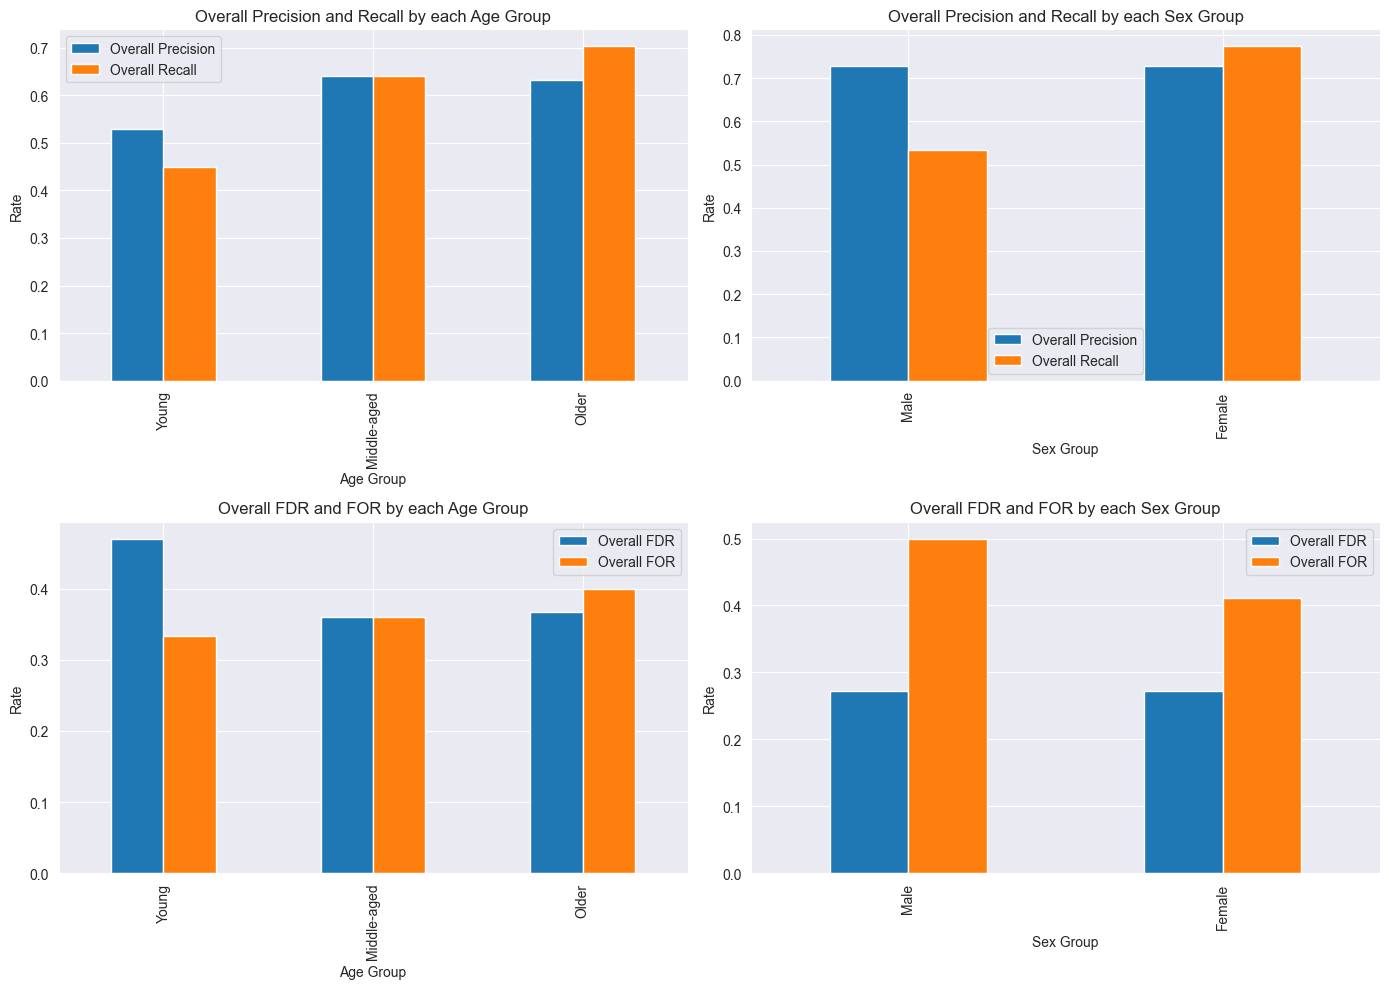

In [8]:
# Create subplots with 2 plots per row for Overall Precision, Recall, FDR, and FOR
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall Precision and Recall by Age Group
age_metrics[['Overall Precision', 'Overall Recall']].plot(kind='bar', ax=axes[0, 0], title='Overall Precision and Recall by each Age Group')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Rate')

# Overall Precision and Recall by Sex Group
sex_metrics[['Overall Precision', 'Overall Recall']].plot(kind='bar', ax=axes[0, 1], title='Overall Precision and Recall by each Sex Group')
axes[0, 1].set_xlabel('Sex Group')
axes[0, 1].set_ylabel('Rate')

# Overall FDR and FOR by Age Group
age_metrics[['Overall FDR', 'Overall FOR']].plot(kind='bar', ax=axes[1, 0], title='Overall FDR and FOR by each Age Group')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Rate')

# Overall FDR and FOR by Sex Group
sex_metrics[['Overall FDR', 'Overall FOR']].plot(kind='bar', ax=axes[1, 1], title='Overall FDR and FOR by each Sex Group')
axes[1, 1].set_xlabel('Sex Group')
axes[1, 1].set_ylabel('Rate')

plt.tight_layout()
plt.show()


### Plot Presence and Absence Metrics by Age and Sex Experiments

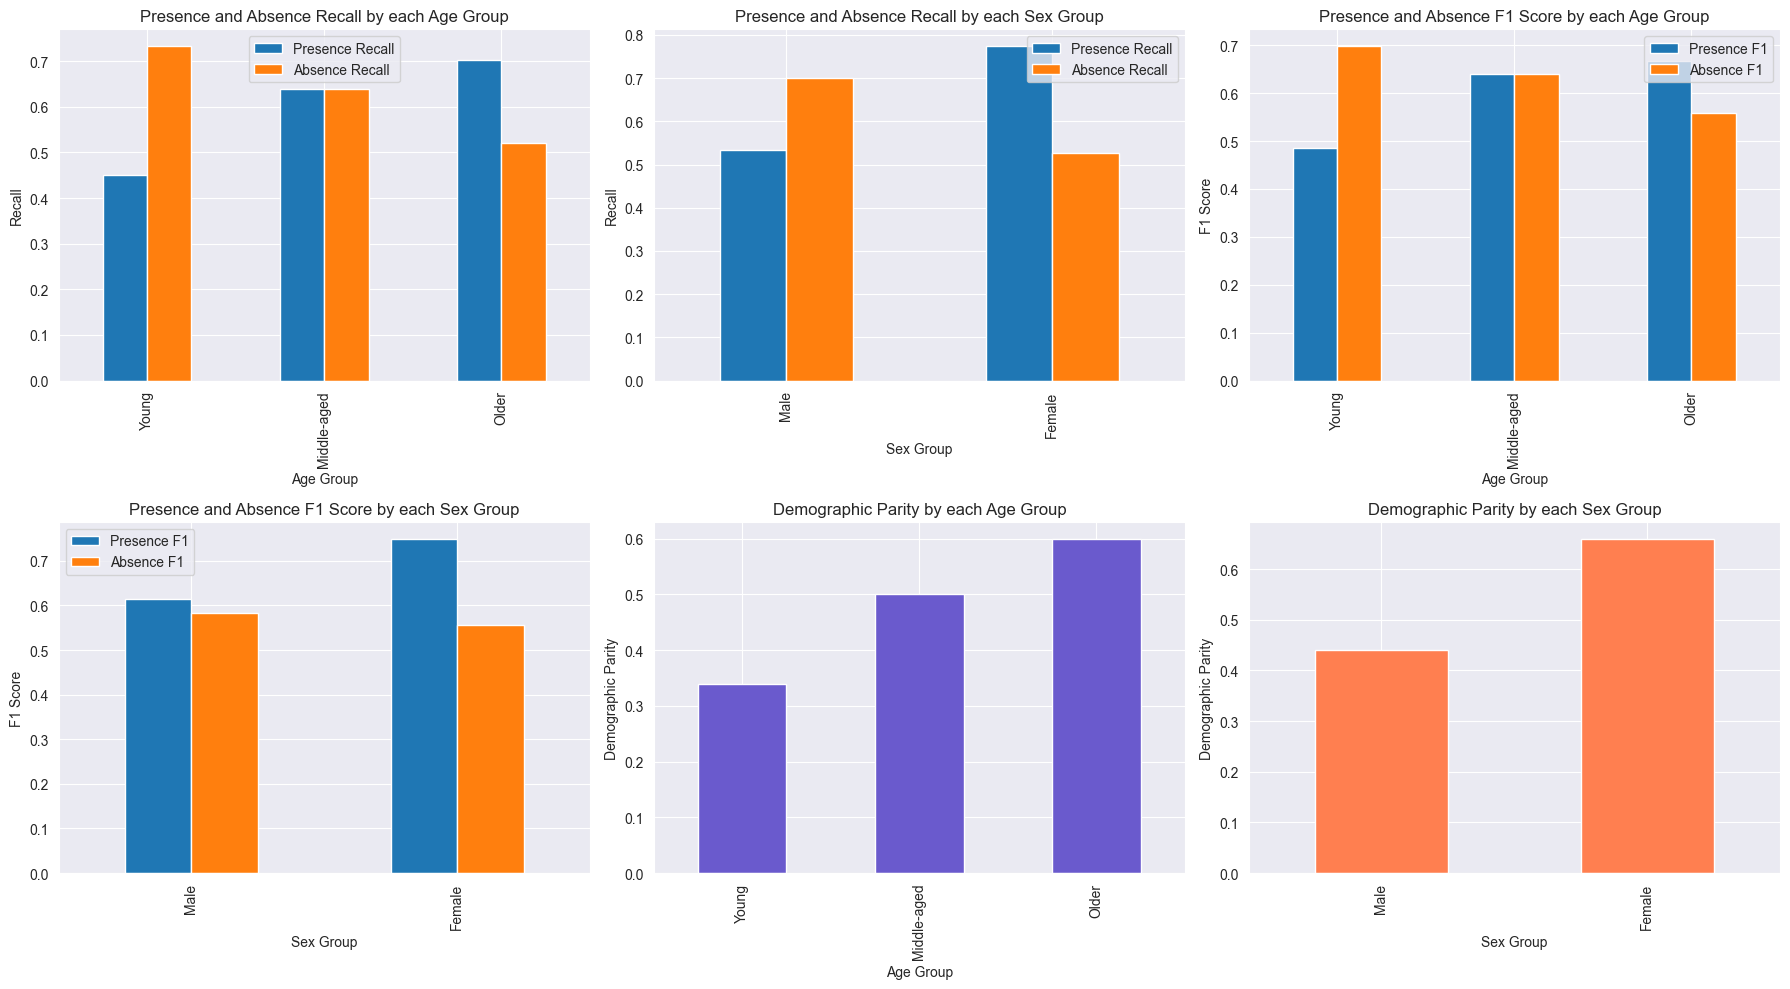

In [10]:
# Create subplots with 3 plots per row for presence and absence recall and F1 scores
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Presence and Absence Recall by each Age Group
age_metrics[['Presence Recall', 'Absence Recall']].plot(kind='bar', ax=axes[0, 0], title='Presence and Absence Recall by each Age Group')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Recall')

# Presence and Absence Recall by each Sex Group
sex_metrics[['Presence Recall', 'Absence Recall']].plot(kind='bar', ax=axes[0, 1], title='Presence and Absence Recall by each Sex Group')
axes[0, 1].set_xlabel('Sex Group')
axes[0, 1].set_ylabel('Recall')

# Presence and Absence F1 Score by each Age Group
age_metrics[['Presence F1', 'Absence F1']].plot(kind='bar', ax=axes[0, 2], title='Presence and Absence F1 Score by each Age Group')
axes[0, 2].set_xlabel('Age Group')
axes[0, 2].set_ylabel('F1 Score')

# Presence and Absence F1 Score by each Sex Group
sex_metrics[['Presence F1', 'Absence F1']].plot(kind='bar', ax=axes[1, 0], title='Presence and Absence F1 Score by each Sex Group')
axes[1, 0].set_xlabel('Sex Group')
axes[1, 0].set_ylabel('F1 Score')

# Demographic Parity by Age Group
age_metrics['Overall Demographic Parity'].plot(kind='bar', ax=axes[1, 1], color='slateblue', title='Demographic Parity by each Age Group')
axes[1, 1].set_xlabel('Age Group')
axes[1, 1].set_ylabel('Demographic Parity')

# Demographic Parity by Sex Group
sex_metrics['Overall Demographic Parity'].plot(kind='bar', ax=axes[1, 2], color='coral', title='Demographic Parity by each Sex Group')
axes[1, 2].set_xlabel('Sex Group')
axes[1, 2].set_ylabel('Demographic Parity')

plt.tight_layout()
plt.show()